In [47]:
import os
import itertools
import numpy as np
from matplotlib import pyplot, ticker
import math

from PySDM import Builder, Formulae
from PySDM.dynamics import Freezing
from PySDM.environments import Box
from PySDM.physics import constants_defaults as const
from PySDM.physics import si
from PySDM.products import IceWaterContent
from PySDM.backends import CPU, GPU

from open_atmos_jupyter_utils import show_plot

In [157]:
CI = 'CI' in os.environ

RATE_MARGIN = .15
TIME_MARGIN = .25

DTS = (500, 1000, 2000, 4000, 8000, 16000) if not CI else (16000,)
MLT = (1, 4, 16, 64, 256, 1024) if not CI else (4096,)
SEEDS = (11, 22, 33, 44, 55, 66, 77, 88) if not CI else (99,)

def error_norm(actual, expected):
    return np.sqrt(np.mean(np.square(actual - expected)))

In [3]:
cases = tuple([{"dt": dt, "N": mlt, "seed": seed} for dt, mlt, seed in itertools.product(DTS, MLT, SEEDS)])
rate = 1e-9 / si.s
immersed_surface_area = 1 * si.m

number_of_real_droplets = 256 * max(MLT)
total_time = (
    1e7  # effectively interpreted here as seconds, i.e. cycle = 1 * si.s
)

# dummy (but must-be-set) values
vol = (
    44  # for sign flip (ice water has negative volumes), value does not matter
)
d_v = 666  # products use conc., dividing there, multiplying here, value does not matter

output = {}

products = (IceWaterContent(name="qi"),)

for backend_class in (GPU,):
    backend_key = backend_class.__name__
    output[backend_key] = {}
    for case in cases:
        formulae = Formulae(
            heterogeneous_ice_nucleation_rate="Constant",
            constants={"J_HET": rate / immersed_surface_area},
            seed=case['seed'],
        )
        
        n_sd = int(number_of_real_droplets // case["N"])
        assert n_sd == number_of_real_droplets / case["N"]
        assert total_time // case["dt"] == total_time / case["dt"]

        key = f"{case['dt']}:{n_sd}:{case['seed']}"
        print(key, "...")
        output[backend_key][key] = {"unfrozen_fraction": [], "dt": case["dt"], "N": case["N"]}

        builder = Builder(n_sd=n_sd, backend=backend_class(formulae=formulae))
        env = Box(dt=case["dt"], dv=d_v)
        builder.set_environment(env)
        builder.add_dynamic(Freezing(singular=False))
        attributes = {
            "multiplicity": np.full(n_sd, int(case["N"])),
            "immersed surface area": np.full(n_sd, immersed_surface_area),
            "volume": np.full(n_sd, vol),
        }
        particulator = builder.build(attributes=attributes, products=products)
        env["RH"] = 1.0001
        env["a_w_ice"] = np.nan
        env["T"] = np.nan

        cell_id = 0
        for i in range(int(total_time / case["dt"]) + 1):
            particulator.run(0 if i == 0 else 1)

            ice_mass_per_volume = particulator.products["qi"].get()[cell_id]
            ice_mass = ice_mass_per_volume * d_v
            ice_number = ice_mass / (const.rho_w * vol)
            unfrozen_fraction = 1 - ice_number / number_of_real_droplets
            output[backend_key][key]["unfrozen_fraction"].append(unfrozen_fraction)

500:262144:11 ...
500:262144:22 ...
500:262144:33 ...
500:262144:44 ...
500:262144:55 ...
500:262144:66 ...
500:262144:77 ...
500:262144:88 ...
500:65536:11 ...
500:65536:22 ...
500:65536:33 ...
500:65536:44 ...
500:65536:55 ...
500:65536:66 ...
500:65536:77 ...
500:65536:88 ...
500:16384:11 ...
500:16384:22 ...
500:16384:33 ...
500:16384:44 ...
500:16384:55 ...
500:16384:66 ...
500:16384:77 ...
500:16384:88 ...
500:4096:11 ...
500:4096:22 ...
500:4096:33 ...
500:4096:44 ...
500:4096:55 ...
500:4096:66 ...
500:4096:77 ...
500:4096:88 ...
500:1024:11 ...
500:1024:22 ...
500:1024:33 ...
500:1024:44 ...
500:1024:55 ...
500:1024:66 ...
500:1024:77 ...
500:1024:88 ...
500:256:11 ...
500:256:22 ...
500:256:33 ...
500:256:44 ...
500:256:55 ...
500:256:66 ...
500:256:77 ...
500:256:88 ...
1000:262144:11 ...
1000:262144:22 ...
1000:262144:33 ...
1000:262144:44 ...
1000:262144:55 ...
1000:262144:66 ...
1000:262144:77 ...
1000:262144:88 ...
1000:65536:11 ...
1000:65536:22 ...
1000:65536:33 ...
10

In [40]:
def hgh(t):
    return np.exp(-(1-RATE_MARGIN) * rate * (t - total_time * TIME_MARGIN))

def low(t):
    return np.exp(-(1+RATE_MARGIN) * rate * (t + total_time * TIME_MARGIN))

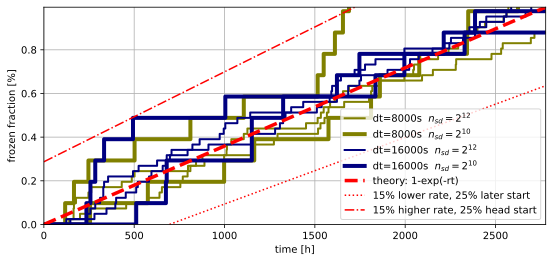

HTML(value="<a href='./fig_convergence_ThrustRTC.pdf' target='_blank'>./fig_convergence_ThrustRTC.pdf</a><br>"…

In [168]:
for backend_key in output.keys():
    fig, ax = pyplot.subplots(1, 1, figsize=(9, 4))
    for key, out in output[backend_key].items():
        dt, n_sd, seed = key.split(':')
        fit_x = np.linspace(0, total_time, num=100)
        fit_y = np.exp(-rate * fit_x)

        sim_x = out["dt"] * np.arange(len(out["unfrozen_fraction"]))
        sim_y = np.asarray(out["unfrozen_fraction"])
        if int(dt) in DTS[-2:] and number_of_real_droplets//int(n_sd) in MLT[3:5] and int(seed) in SEEDS[-2:]:
            ax.step(
                sim_x / 60 / 60,
                (1-sim_y) * 100,
                label=f"dt={out['dt']:g}s  $n_{{sd}}=2^{{{int(np.log2(int(n_sd)))}}}$" if int(seed) != SEEDS[-1] else "",
                color={DTS[-2]: 'olive', DTS[-1]: 'navy'}[int(dt)],
                linewidth=2 + out["N"] // 128,
            )
        output[backend_key][key]['mse'] = error_norm(
            actual=sim_y[1:],
            expected=np.exp(-rate * sim_x[1:])
#             expected=(1-rate * sim_x[1:])
        )
    ax.plot(
        fit_x / 60 / 60, (1-fit_y) * 100, color="red", linestyle="--", label="theory: 1-exp(-rt)", linewidth=3.5
    )
    ax.plot(
        fit_x / 60 / 60, (1-hgh(fit_x)) * 100, color="red", linestyle=":", label=f"{100*RATE_MARGIN:g}% lower rate, {100*TIME_MARGIN:g}% later start"
    )
    ax.plot(
        fit_x / 60 / 60, (1-low(fit_x)) * 100, color="red", linestyle="-.", label=f"{100*RATE_MARGIN:g}% higher rate, {100*TIME_MARGIN:g}% head start"
    )
    ax.legend(loc='lower right')
    ax.set_ylim(100 * (1-fit_y[0]), 100 * (1-fit_y[-1]))
    ax.set_xlim(0, total_time / 60 / 60)
    ax.set_xlabel("time [h]")
    ax.set_ylabel("frozen fraction [%]")
    ax.grid()
    show_plot(f"fig_convergence_{backend_key}.pdf")

In [165]:
mean = {}
serr = {}
for backend_key in output.keys():
    mean[backend_key] = {}
    serr[backend_key] = {} 
    for n_real in range(1, len(SEEDS)+1):
        mean[backend_key][n_real] = np.zeros(shape=(len(DTS), len(MLT)))
        serr[backend_key][n_real] = np.zeros(shape=(len(DTS), len(MLT)))
        tmp = serr[backend_key][n_real]
        for key in output[backend_key].keys():
            dt, n_sd, seed = key.split(':')
            if int(seed) in SEEDS[0:n_real]:
                i = DTS.index(float(dt))
                j = MLT.index(number_of_real_droplets // int(n_sd))
                mse = output[backend_key][key]['mse']
                mean[backend_key][n_real][i, j] += mse
                tmp[i, j] += mse**2
        mean[backend_key][n_real] /= n_real
        tmp /= n_real
        tmp -= mean[backend_key][n_real]**2
        mask = tmp > 0
        serr[backend_key][n_real][mask] = np.sqrt(tmp[mask] / n_real)
        serr[backend_key][n_real][~mask] = 0

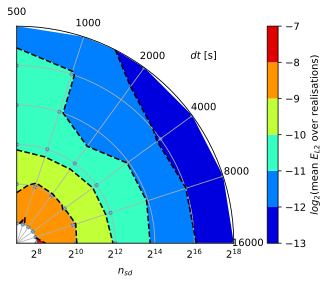

HTML(value="<a href='./fig_contours_particles_ThrustRTC.pdf' target='_blank'>./fig_contours_particles_ThrustRT…

In [166]:
def phi(dts):
    l2dts = np.log2(dts)
    scaled = (l2dts - min(l2dts)) / (max(l2dts) - min(l2dts))
    return scaled * np.pi / 2

def rho(n):
    return np.log2(n)

for backend_key in output.keys():
    theta_array = phi(total_time // np.asarray(DTS))
    r_array = rho(number_of_real_droplets // np.asarray(MLT))

    X, Y = np.meshgrid(theta_array, r_array)
    Z = np.array(list(np.log2(mean[backend_key][len(SEEDS)]))).T.reshape(len(MLT), len(DTS))
        
    rng = [math.floor(np.amin(Z)), math.ceil(np.amax(Z))]
    levels = np.linspace(*rng, rng[-1] - rng[0] + 1)
    
    ax = pyplot.subplot(111, projection='polar')
    cnt = ax.contourf(X, Y, Z, levels, cmap='jet')
    pyplot.contour(X, Y, Z, levels, colors='black')
    
    ax.scatter(X, Y, alpha=.8, s=10)
    legend = pyplot.colorbar(cnt, ax=ax, pad=0.1)
    legend.set_label(r'$log_2$(mean $E_{L2}$ over realisations)', rotation=90)

    ax.set_xlabel(r"$n_{sd}$", labelpad=18)
    ax.set_rlim(min(r_array) - 1, max(r_array))
    ax.set_yticks(r_array)
    ax.set_yticklabels("$2^{" + f"{int(tick):d}" + "}$" for tick in r_array)
    
    ax.annotate(r'$dt$ [s]', xy=(.8, .85), xycoords='axes fraction')
    ax.set_thetalim(min(theta_array), max(theta_array))
    ax.set_thetagrids(theta_array / (np.pi/2) * 90, tuple(f"{dt:d}" for dt in DTS))

    ax.grid(True)
    
    show_plot(f'fig_contours_particles_{backend_key}.pdf')

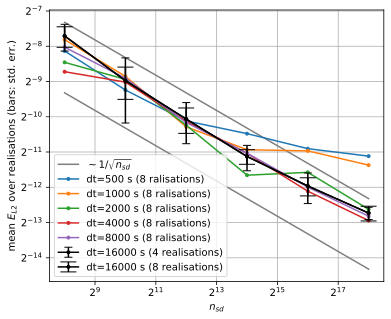

HTML(value="<a href='./fig_lines_ThrustRTC.pdf' target='_blank'>./fig_lines_ThrustRTC.pdf</a><br>")

In [167]:
for backend_key in output.keys():
    fig, ax = pyplot.subplots(1, 1, figsize=(6, 5))
    pick_n_real = len(SEEDS)
    pick_dt = -1
    
    x = number_of_real_droplets // np.asarray(MLT)
    for i, c in enumerate((.025, .1)):
        ax.plot(x, c * x**-.5, color='gray', label='$\sim 1/\sqrt{n_{sd}}$' if i==0 else '')

    for i, dt in enumerate(DTS):
        x = number_of_real_droplets // np.asarray(MLT)
        y = mean[backend_key][pick_n_real][i, :]
        common_kwargs = {'marker': '.'} #, 'linewidth': 200/np.sqrt(float(dt))}
        label = f"dt={dt} s"
        if dt == DTS[pick_dt]:
            for n_real in range(1, len(SEEDS)+1):
                if n_real < 4 or np.log2(n_real) != int(np.log2(n_real)):
                    continue
                ax.errorbar(x=x, y=y,
                    yerr=serr[backend_key][n_real][i, :],
                    capsize=n_real,
                    **common_kwargs,
                    color='black',
                    label=label + f" ({n_real} realisations)"
                )
        else:
            ax.plot(x, y, **common_kwargs, label=label + f" ({len(SEEDS)} ralisations)")
            
    pyplot.xscale('log', base=2)
    pyplot.yscale('log', base=2)
    pyplot.legend(loc="lower left")
    pyplot.xlabel("$n_{sd}$")
    pyplot.ylabel(r'mean $E_{L2}$ over realisations (bars: std. err.)')
    pyplot.grid()
    show_plot(f'fig_lines_{backend_key}.pdf')